# Beatmap Visual Analysis

In [2]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
import datetime as dt
from pymongo import MongoClient
from jupyterthemes import jtplot


In [3]:
# mongodb
client = MongoClient('localhost:27017')
db = client['Beatmaps']

# graph theme
jtplot.style(theme='gruvboxd')

In [4]:
# beatmap fields
doc = db['standard'].find_one({})
fields = list(doc.keys())
fields.remove('_id')

modes = ['standard', 'taiko', 'catch', 'mania']

In [18]:
### mode data frames
approved_status = 1

collection_standard = db['standard']
data_standard = [doc for doc in collection_standard.find({'approved': approved_status})]
df_standard = pd.DataFrame(data_standard)

collection_taiko = db['taiko']
data_taiko = [doc for doc in collection_taiko.find({'approved': approved_status})]
df_taiko = pd.DataFrame(data_taiko)

collection_catch = db['catch']
data_catch = [doc for doc in collection_catch.find({'approved': approved_status})]
df_catch = pd.DataFrame(data_catch)

collection_mania = db['mania']
data_mania = [doc for doc in collection_mania.find({'approved': approved_status})]
df_mania = pd.DataFrame(data_mania)



In [6]:
def getDf(mode):
    return {
        'standard': df_standard,
        'taiko': df_taiko,
        'catch': df_catch,
        'mania': df_mania,
    }.get(mode)


def getMode(data_frame):
    """function gets the mode of a data_frame data set
    @param data_frame (pd.DataFrame) - pandas data frame
    @return mode (str) - osu! game mode
    """
    mode_index = int( data_frame['mode'][0] )
    mode = modes[mode_index]
    
    return mode


    

# Star Rating

In [77]:
### star difficulty analysis
# distribution
def analyzeStarDiff(mode, bulk=False):
    """"""
    df_mode = getDf(mode)
    
    if not bulk:
        ax = sns.kdeplot(df_mode['difficultyrating'], shade=True, color='b', legend=False)
        # resizing y ticks ### kde by definition has to be normalized (cant have count on y-axis)
#         resize = lambda x: round((x * data['difficultyrating'].size) / 500) * 500
#         resizeFunc = np.vectorize(resize)
#         y_ticks = ax.get_yticks()
#         # y_ticks = resizeFunc(y_ticks)
#         # ax.set_yticks(y_ticks)

        # x ticks
        ax.set_xticks(np.arange(0,10))
        ax.xaxis.set_major_locator(MultipleLocator(1.000))
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        
    else: # bulk by star (int) i.e. 2, 3, 4, 5 star (categorical)
        star_diffs = df_mode['difficultyrating'].astype('int64')
        ax = sns.countplot(x=star_diffs, saturation=.9)
#         fig, ax = plt.subplots(nrows=1)
#         ax.hist(x=star_diffs, bins=np.arange(0, 10, 1), align='left')
        ax.grid(b=False)
        ax.set_xticks(np.arange(0,10))
        
    ax.set_title("Beatmap Star Rating in osu!{}".format(mode), fontsize=18, pad=10)
    ax.set_xlabel("Star Difficulty")
    ax.set_ylabel("Number of Beatmaps")


C:\Users\camen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


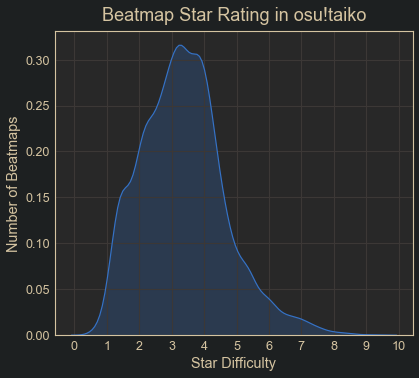

In [110]:
# analyzeStarDiff(getDf(mode='standard'), bulk=False)
analyzeStarDiff('taiko', bulk=False)

# Length

In [111]:
# look at total_length vs. hit_length
def graphLength(mode='standard', length='total_length', kernel='gau'):
    """
    Kernels: {‘gau’ | ‘cos’ | ‘biw’ | ‘epa’ | ‘tri’ | ‘triw’ }
    """
    df_mode = getDf(mode)
    length_data = df_mode[length]
    # length_data_trim = length_data.sort_values(axis=0, ascending=False)[trim_count:]

    ax = sns.kdeplot(length_data, kernel=kernel, shade=True, color='b', \
                     legend=False, cbar=True,)
    
    ax.set_title("Distribution of Beatmap Lengths in osu!{}".format(getMode(df_mode)), fontsize=22, pad=20)
    ax.set_ylabel("Distribution", size=24)
    ax.set_xlabel("Seconds", size=24)
    
    ax.xaxis.set_major_locator(MultipleLocator(60.000))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    
    ax.set_xlim(0, 480)
    
    ax.tick_params(which='major', width=2, length=10, labelsize=14)
    ax.tick_params(which='minor', width=1, length=5, labelsize=10)
    
    

C:\Users\camen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


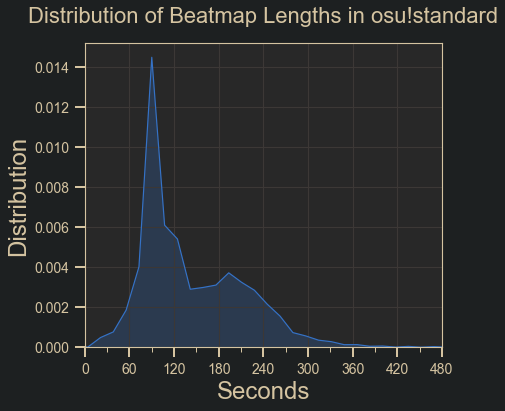

In [116]:
graphLength('standard', kernel='gau')

# Genre and Language

In [175]:
def sortLabels(data_series, labels):
    """"""
    sorted_labels = []
    data_count = data_series.value_counts()
    data_sort = data_count.sort_values(ascending=False)
    
    for index, val in data_sort.iteritems():
        sorted_labels.append(labels[index])
        
    return sorted_labels

def truncateData(df, name_id, threshold_percent=1.00):
    """all labels that that make up less than 1%, put them into an 'other category'
    """
    if name_id not in "language_id genre_id":
        raise ValueError("Invalid name_id parameter.")
    
    initial_size = sum(df['count'])
    other_id = int( df[df['name'] == 'Other'][name_id] )
    
    df = df[df['percent'] >= threshold_percent]
    df = df[df['name'] != 'other']
    
    resize = sum(df['count'])
    other_count = initial_size - resize
    other_percent = round(((other_count / initial_size) * 100), 2)

    df.loc[len(df.index)] = [other_id, other_count, 'Other', other_percent]
    
    return df

def getGenreOrLangDf(mode_df, names, name_id):
    """"""
    ### counts column
    data_series = mode_df[name_id]
    data_counts = data_series.value_counts()
    df = pd.DataFrame(data_counts)
    df.columns = ['count']
    
    ### name column
    names = sortLabels(data_series, names)
    df['name'] = names
    
    ### percent column
    percentFunc = lambda x: round((x / data_series.size) * 100, 2)
    percents = list(map(percentFunc, df['count']))
    df['percent'] = percents
    
    ### reset index
    df = df.reset_index()
    
    ### genre_id column
    df = df.rename(columns={'index': name_id})
    
    return df

In [191]:
def analyzeGenre(mode):
    genres = ['Any', 'Unspecified', 'Video Game', 'Anime', \
              'Rock', 'Pop', 'Other', 'Novelty', None, \
              'Hip Hop', 'Electronic']
    mode_df = getDf(mode)

    genre_df = getGenreOrLangDf(mode_df, genres, 'genre_id')
    genre_df = truncateData(genre_df, 'genre_id', 5)
    print(genre_df)
    
    fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
    ax = plt.pie(x=genre_df['percent'], labels=genre_df['name'], shadow=True, \
                 startangle=90, wedgeprops={'linewidth': 3})
#     ax.set_title("Genres in osu!{}".format(getMode(data_frame)))
    plt.axis('equal')
    

   genre_id  count        name  percent
0         3  19878       Anime    32.34
1         2  17711  Video Game    28.81
2         5   7234         Pop    11.77
3        10   5611  Electronic     9.13
4         7   4999     Novelty     8.13
5         4   3419        Rock     5.56
6         6   2616       Other     4.26


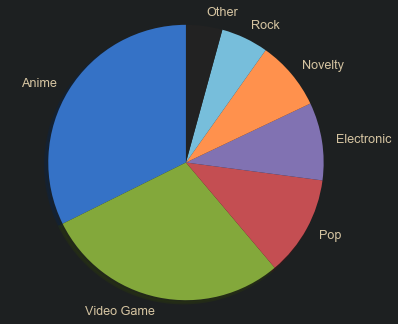

In [192]:
analyzeGenre('standard')

In [197]:
def analyzeLanguage(mode):
    """"""
    languages = ['Any', 'Other', 'English', 'Japanese', \
                 'Chinese', 'Instrumental', 'Korean', \
                 'French', 'German', 'Swedish', 'Spanish', 'Italian']
    mode_df = getDf(mode)
    
    lang_df = getGenreOrLangDf(mode_df, languages, 'language_id')
    lang_df = truncateData(lang_df, 'language_id', 5)
    print(lang_df)
    
    fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
    ax = plt.pie(x=lang_df['percent'], labels=lang_df['name'], shadow=True, \
                 startangle=90, wedgeprops={'linewidth': 3})
    # ax.set_title("Genres in osu!{}".format(getMode(data_frame)))
    plt.axis('equal')
    

   language_id  count          name  percent
0            3  35201      Japanese    57.27
1            5  11920  Instrumental    19.39
2            2   9993       English    16.26
3            1   4354         Other     7.08


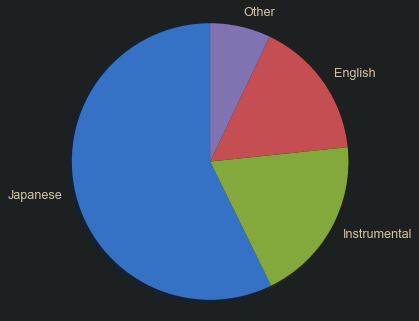

In [203]:
analyzeLanguage('standard')

# Date

In [ ]:
def getQuarter(date):
    """
    # Example Date: '2007-10-06 17:46:31'
    """
    month = date[5:7]
    if month in "01 02 03":
        return '1'
    elif month in "04 05 06":
        return '2'
    elif month in "07 08 09":
        return '3'
    elif month in "10 11 12":
        return '4'
    else:
        raise ValueError("Invalid 'date' paramter.")

def getBi(date):
    """
    # Example Date: '2007-10-06 17:46:31'
    """
    month = date[5:7]
    if month in "01 02 03 04 05 06":
        return '1'
    elif month in "07 08 09 10 11 12":
        return '2'
    else:
        raise ValueError("Invalid 'date' parameter.")

In [ ]:
def graphDateYear(mode):
    """"""
    df_mode = getDf(mode)
    date_data = df_mode['approved_date']
    
    years_data = [date[:4] for date in date_data]
    ax = sns.countplot(x=years_data, saturation=.75, palette=sns.color_palette("Set1", n_colors=15, desat=.75))
   
    ax.set_title("Number of Approved Beatmaps Each Year for osu!{}".format(mode), size=24, pad=16)
    ax.set_xlabel("Year", size=24, labelpad=16)
    ax.set_ylabel("Number of Beatmaps", size=24, labelpad=16)
    ax.tick_params(axis='x', labelrotation=-50, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(b=False)
        
#     elif time == 'bi':
#         bi_data = []
#         for date in date_data:
#             year = date[:4]
#             bi = getBi(date)
#             bi_d = year + '_' + bi
#             bi_data.append(bi_d)
        
#         ax = sns.countplot(x=bi_data)
    
#     elif time == 'quarter':
#         quarter_data = []
#         for date in date_data:
#             year = date[:4]
#             quarter = getQuarter(date)
#             quarter_d = year + '_' + quarter
#             quarter_data.append(quarter_d)
        
#         ax = sns.countplot(x=quarter_data)
        
#     elif time == 'month':
#         months_data = [date[:7] for date in date_data]
#         ax = sns.countplot(x=months_data, saturation=1)

#     else:
#         raise ValueError("Invalid 'time' parameter.")
    
    #print(df)
    

In [ ]:
def graphTime(mode):
    df_mode = getDf(mode)
    time_data = df_mode['approved_date']
    convertTime = lambda t: dt.datetime.strptime(t, "%Y-%m-%d %H:%M:%S")
    time_data = time_data.map(convertTime)
    time_data = time_data.sort_values(ascending=True)
    
    week = dt.timedelta(days=7)
    weeks_data = []
    week_start = time_data[0]
    i = 0
    while i < len(time_data):
        count = 0
        try:
            while (time_data.iloc[i] - week_start).days < 7:
                count += 1
                i += 1
        except IndexError:
            weeks_data.append(count)
            break
        week_start += week
        i += 1
        weeks_data.append(count)
    
    weeks = np.arange(0, len(weeks_data) * 7, 7)
    
    fig, ax = plt.subplots(nrows=1)
    ax.plot(weeks, weeks_data)
        


In [ ]:
graphTime('standard')

In [ ]:
graphDateYear('standard')
# analyzeDate(df, time='bi')
# analyzeDate(df, time='quarter')
# analyzeDate(df, time='month')

# Difficulties - Circle Size (CS), Overall Difficulty (OD), HP Drain (HP), Approach Rate (AR)


In [ ]:
def graphDiff(mode, diff_type):
    """
    Difficulty types: 
           CS -> diff_size
           OD -> diff_overall
           HP -> diff_drain
           AR -> diff_approach
           
    """
    type_info = {
        'CS': ('Circle Size', 'diff_size'),
        'OD': ('Overall Difficulty', 'diff_overall'),
        'HP': ('HP Drain', 'diff_drain'),
        'AR': ('Approach Rate', 'diff_approach'),
    }
    name, diff_field = type_info.get(diff_type)
    
    mode_df = getDf(mode)
    diff_data = mode_df[diff_field]
    ax = sns.kdeplot(data=diff_data, shade=True, bw=0.05, legend=False)
    
    ax.set_xticks(np.arange(0,12,1))
    
    ax.set_xlabel("{} ({})".format(name, diff_type))
    ax.set_ylabel("Distribution")
    ax.set_title("{} distribution of ranked maps in osu!{}".format(name, mode), fontsize=18)

In [ ]:
graphDiff('standard', 'HP')
# graphDiff('standard', 'OD')
# graphDiff('standard', 'AR')
# graphDiff('standard', 'CS')

# bpm

# Max Combo